# Lab 7: SNNs

Ryan Schaefer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Precision
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, Concatenate, Subtract, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.random.set_seed(7324)
np.random.seed(7324)

# Business Case

Dataset source: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

# Data Preparation

## Load Data

In [2]:
df_fake = pd.read_csv("../Datasets/fake_news/Fake.csv")
df_fake["real_news"] = 0
df_fake["label"] = "Fake"

df_real = pd.read_csv("../Datasets/fake_news/True.csv")
df_real["real_news"] = 1
df_real["label"] = "Real"

labels = ["Fake", "Real"]
df = pd.concat([df_fake, df_real]).reset_index(drop = True)
df

,title,text,subject,date,real_news,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Fake
...,...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1,Real
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1,Real
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1,Real
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1,Real


In [3]:
X_text = np.array(df["text"])
y = np.array(df["real_news"])

X_half, _, y_half, _ = train_test_split(
    X_text, y, test_size=0.5,
    stratify=y, random_state=7324
)

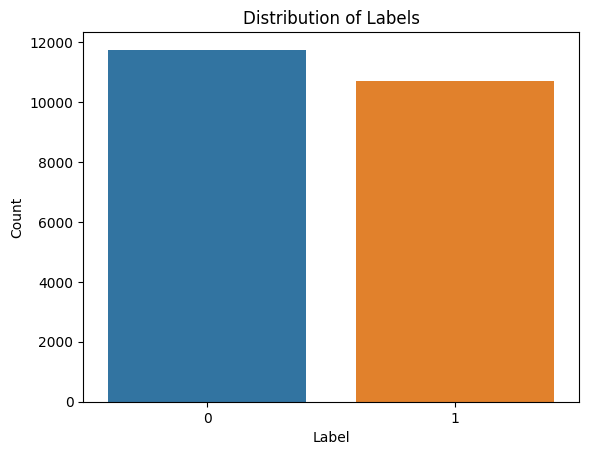

In [4]:
df_half = pd.DataFrame({
    "x": X_half,
    "y": y_half
})

sns.countplot(df_half, x = "y")

plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")

plt.show()

## Tokenization

In [5]:
%%time

NUM_TOP_WORDS = None # use entire vocabulary!

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_half)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X_half)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

Found 101612 unique tokens. Distilled to 101612 top words.
CPU times: user 6.4 s, sys: 49.9 ms, total: 6.45 s
Wall time: 6.02 s


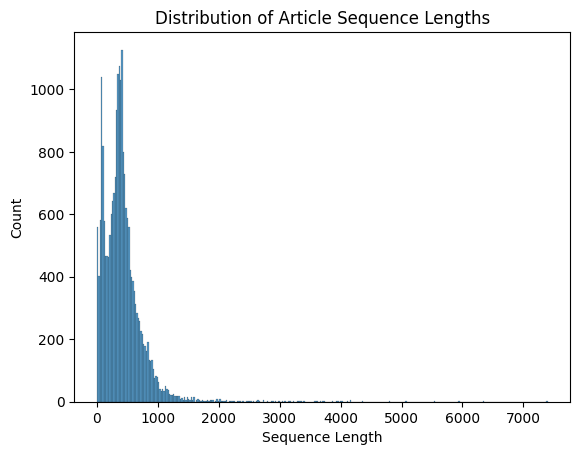

In [6]:
sequence_lengths = list(map(lambda x: len(x), sequences))

sns.histplot(sequence_lengths)

plt.title("Distribution of Article Sequence Lengths")
plt.xlabel("Sequence Length")

plt.show()

In [7]:
MAX_ART_LEN = 1000 # maximum and minimum number of words
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))

Shape of data tensor: (22449, 1000)
Shape of label tensor: (44898,)
101612


## Evaluation Criteria

## Training/Testing Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_half, test_size=0.2,
    stratify=y_half, random_state=7324
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (17959, 1000)
Testing shape: (4490, 1000)


# Modeling

## GloVe Embeddings

In [9]:
%%time

EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../Datasets/glove/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (101613, 100) 
 Total words found: 64127 
 Percentage: 63.10905100725301
CPU times: user 4.9 s, sys: 164 ms, total: 5.06 s
Wall time: 5.06 s


In [10]:
# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

## Model 1 (CNN, Parameter Set 1)

In [11]:
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(35)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model1 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
# Let's train the model 
model1.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=[Precision(name = "precision")]
)

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         10161300  
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 199, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 199, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 195, 128)          82048     
                                                             

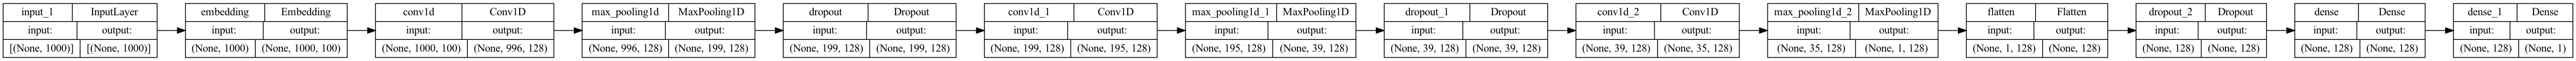

In [12]:
plot_model(
    model1, to_file='model1.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [13]:
%%time

history1 = []
hist1 = model1.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=5, batch_size=128
)
history1.append(hist1)

Epoch 1/5
141/141 [==============================] - 24s 171ms/step - loss: 0.3156 - precision: 0.8998 - val_loss: 0.0337 - val_precision: 0.9962
Epoch 2/5
141/141 [==============================] - 24s 171ms/step - loss: 0.0293 - precision: 0.9905 - val_loss: 0.0291 - val_precision: 0.9930
Epoch 3/5
141/141 [==============================] - 24s 171ms/step - loss: 0.0228 - precision: 0.9927 - val_loss: 0.0253 - val_precision: 0.9921
Epoch 4/5
141/141 [==============================] - 24s 171ms/step - loss: 0.0186 - precision: 0.9936 - val_loss: 0.0246 - val_precision: 0.9871
Epoch 5/5
141/141 [==============================] - 24s 172ms/step - loss: 0.0149 - precision: 0.9942 - val_loss: 0.0228 - val_precision: 0.9972
CPU times: user 16min, sys: 1min 16s, total: 17min 17s
Wall time: 2min 1s


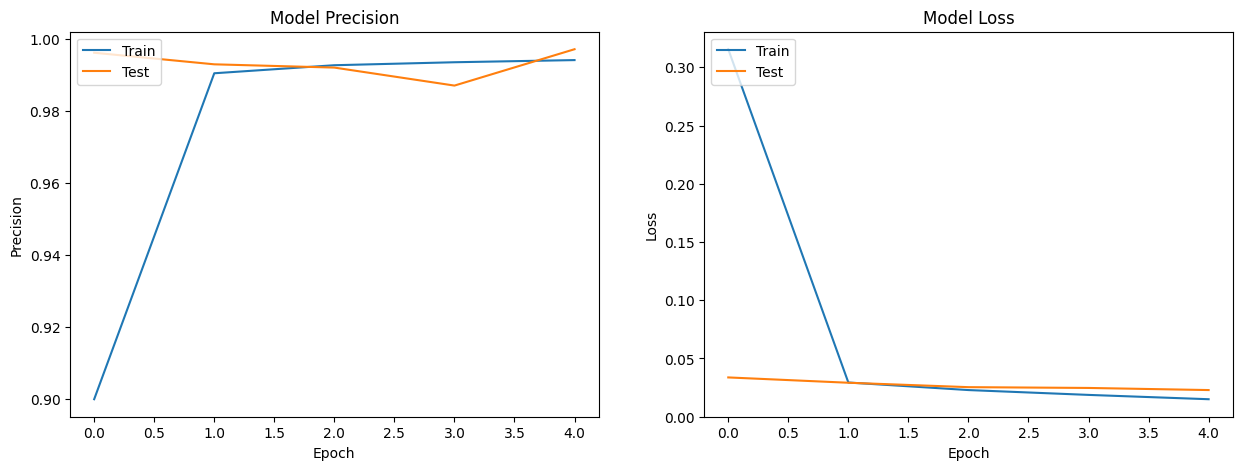

In [14]:
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history1])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [15]:
def compare_models(y, yhat):
    num_models = len(yhat)
    if num_models > 2:
        num_rows = 2
        plt.figure(figsize = (15, 10))
    else:
        num_rows = 1
        plt.figure(figsize = (15, 5))
    num_cols = num_models // num_rows
    if num_rows * num_cols < num_models:
        num_cols += 1
    for i in range(num_models):
        acc = mt.accuracy_score(y, yhat[i])
        precision = mt.precision_score(y, yhat[i])
        plt.subplot(num_rows, num_cols, i+1)
        cm = mt.confusion_matrix(y, yhat[i])
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.4f', xticklabels=labels, yticklabels=labels)
        plt.title(f'Model {i+1}: Accuracy = {acc:.4f}, Precision = {precision:.4f}')
        plt.xlabel("Predicted Class")
        plt.ylabel("Actual Class")

In [16]:
model1_proba = model1.predict(X_test)
model1_pred = np.round(list(map(lambda x: x[0], model1_proba)))

141/141 [==============================] - 2s 14ms/step


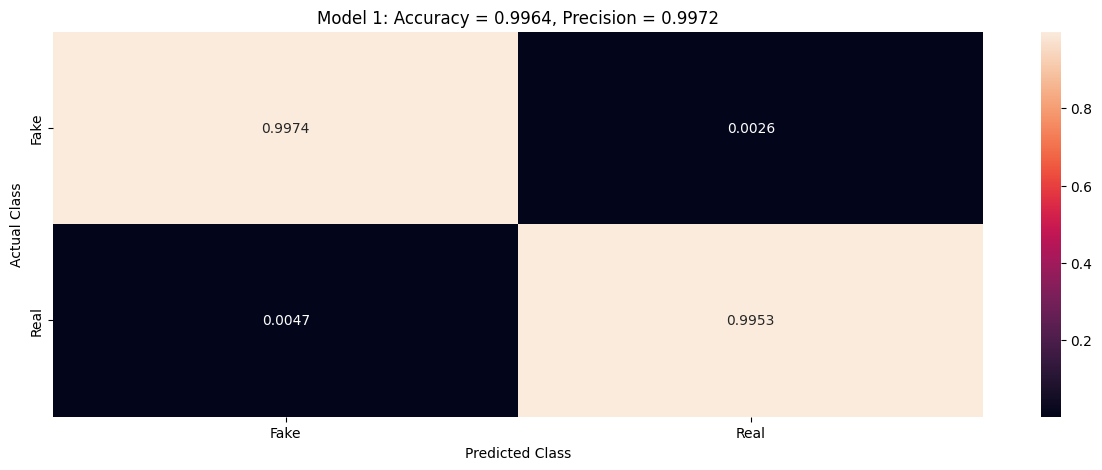

In [17]:
compare_models(y_test, [model1_pred])

## Model 2 (CNN, Parameter Set 2)

In [18]:
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(35)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)
# Added an additional dense layer
x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model2 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
# Let's train the model 
model2.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=[Precision(name = "precision")]
)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         10161300  
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 64)           32064     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 199, 64)           0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 199, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 195, 64)           20544     
                                                           

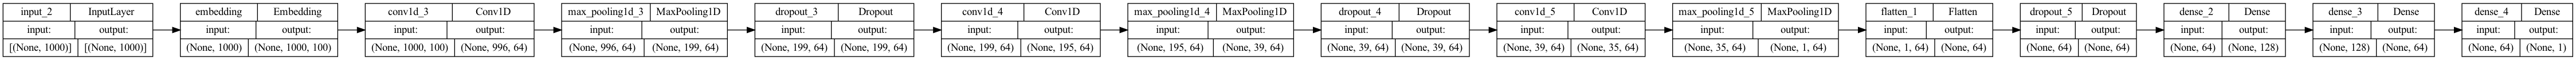

In [19]:
plot_model(
    model2, to_file='model2.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [20]:
%%time

history2 = []
hist2 = model2.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=5, batch_size=128
)
history2.append(hist2)

Epoch 1/5
141/141 [==============================] - 15s 105ms/step - loss: 0.3253 - precision: 0.8442 - val_loss: 0.0453 - val_precision: 0.9976
Epoch 2/5
141/141 [==============================] - 15s 105ms/step - loss: 0.0343 - precision: 0.9908 - val_loss: 0.0232 - val_precision: 0.9939
Epoch 3/5
141/141 [==============================] - 15s 106ms/step - loss: 0.0226 - precision: 0.9923 - val_loss: 0.0298 - val_precision: 0.9839
Epoch 4/5
141/141 [==============================] - 15s 107ms/step - loss: 0.0178 - precision: 0.9952 - val_loss: 0.0244 - val_precision: 0.9848
Epoch 5/5
141/141 [==============================] - 15s 108ms/step - loss: 0.0144 - precision: 0.9954 - val_loss: 0.0197 - val_precision: 0.9963
CPU times: user 7min 57s, sys: 1min 12s, total: 9min 10s
Wall time: 1min 15s


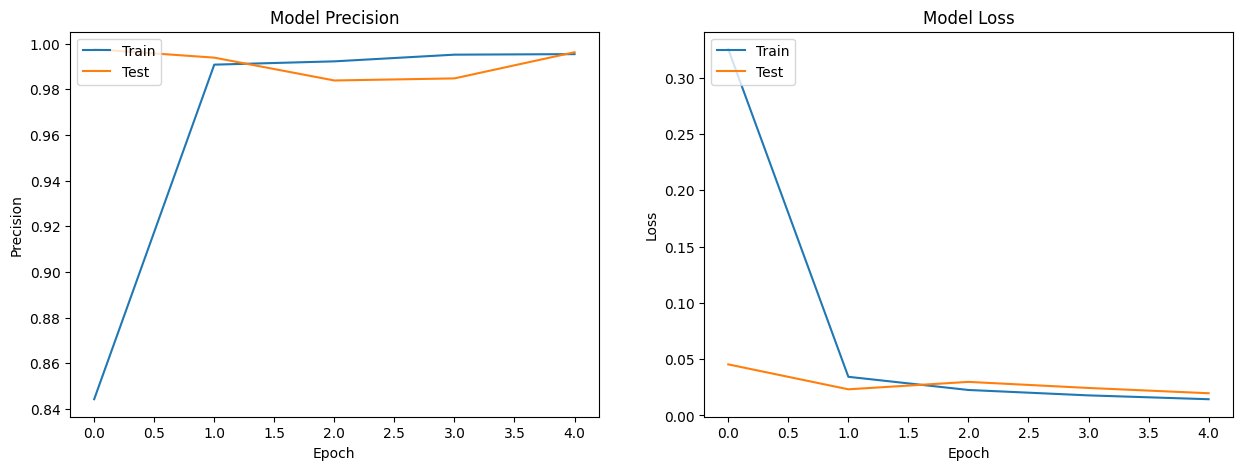

In [21]:
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history2])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [22]:
model2_proba = model2.predict(X_test)
model2_pred = np.round(list(map(lambda x: x[0], model2_proba)))

141/141 [==============================] - 1s 9ms/step


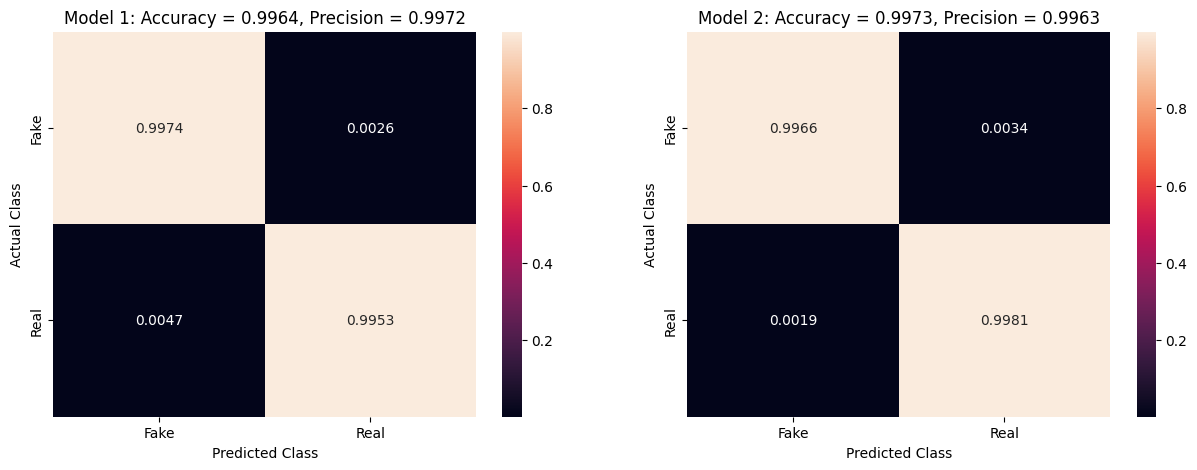

In [23]:
compare_models(y_test, [model1_pred, model2_pred])

## Model 3 (Transformer, Parameter Set 1)

In [24]:
# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2

In [25]:
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN, 
                                 EMBED_SIZE, 
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [26]:
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model3 = Model(inputs=inputs, outputs=preds)

model3.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=[Precision(name = "precision")]
)

model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 glove_token_and_position_e  (None, 1000, 100)         10261300  
 mbedding (GloveTokenAndPos                                      
 itionEmbedding)                                                 
                                                                 
 transformer_block (Transfo  (None, 1000, 100)         87632     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_8 (Dropout)         (None, 100)               0   

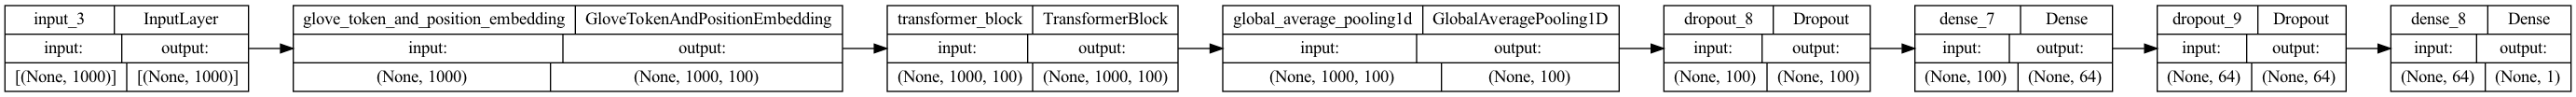

In [27]:
plot_model(
    model3, to_file='model3.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [28]:
%%time

history3 = []
hist3 = model3.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=5, batch_size=128
)
history3.append(hist3)

Epoch 1/5
141/141 [==============================] - 277s 2s/step - loss: 0.3051 - precision: 0.8520 - val_loss: 0.0558 - val_precision: 0.9869
Epoch 2/5
141/141 [==============================] - 277s 2s/step - loss: 0.0748 - precision: 0.9761 - val_loss: 0.0348 - val_precision: 0.9879
Epoch 3/5
141/141 [==============================] - 280s 2s/step - loss: 0.0435 - precision: 0.9833 - val_loss: 0.0229 - val_precision: 0.9907
Epoch 4/5
141/141 [==============================] - 280s 2s/step - loss: 0.0317 - precision: 0.9874 - val_loss: 0.0173 - val_precision: 0.9939
Epoch 5/5
141/141 [==============================] - 279s 2s/step - loss: 0.0237 - precision: 0.9909 - val_loss: 0.0200 - val_precision: 0.9926
CPU times: user 2h 32min 15s, sys: 40min 18s, total: 3h 12min 33s
Wall time: 23min 13s


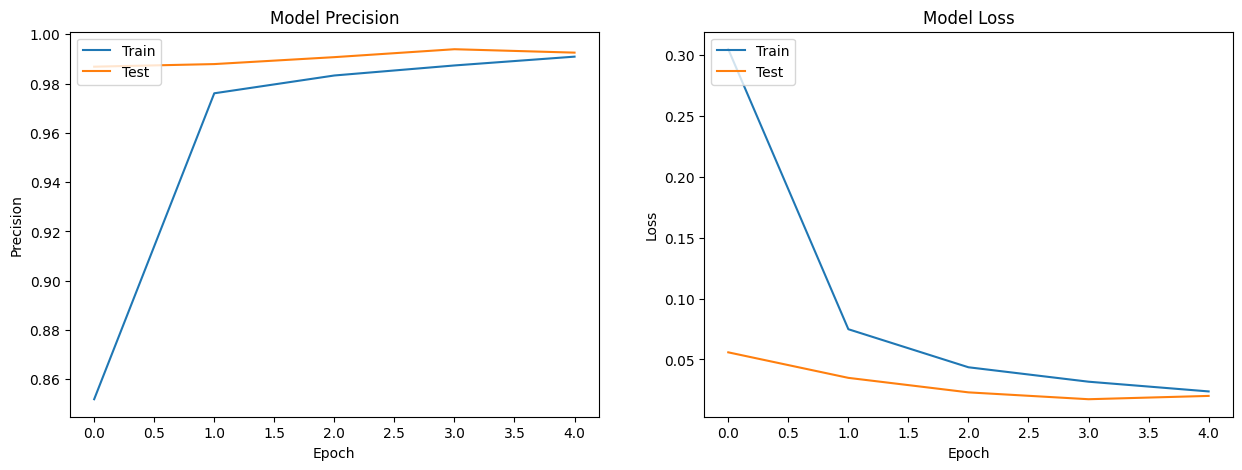

In [29]:
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history3])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [30]:
model3_proba = model3.predict(X_test)
model3_pred = np.round(list(map(lambda x: x[0], model3_proba)))

141/141 [==============================] - 28s 200ms/step


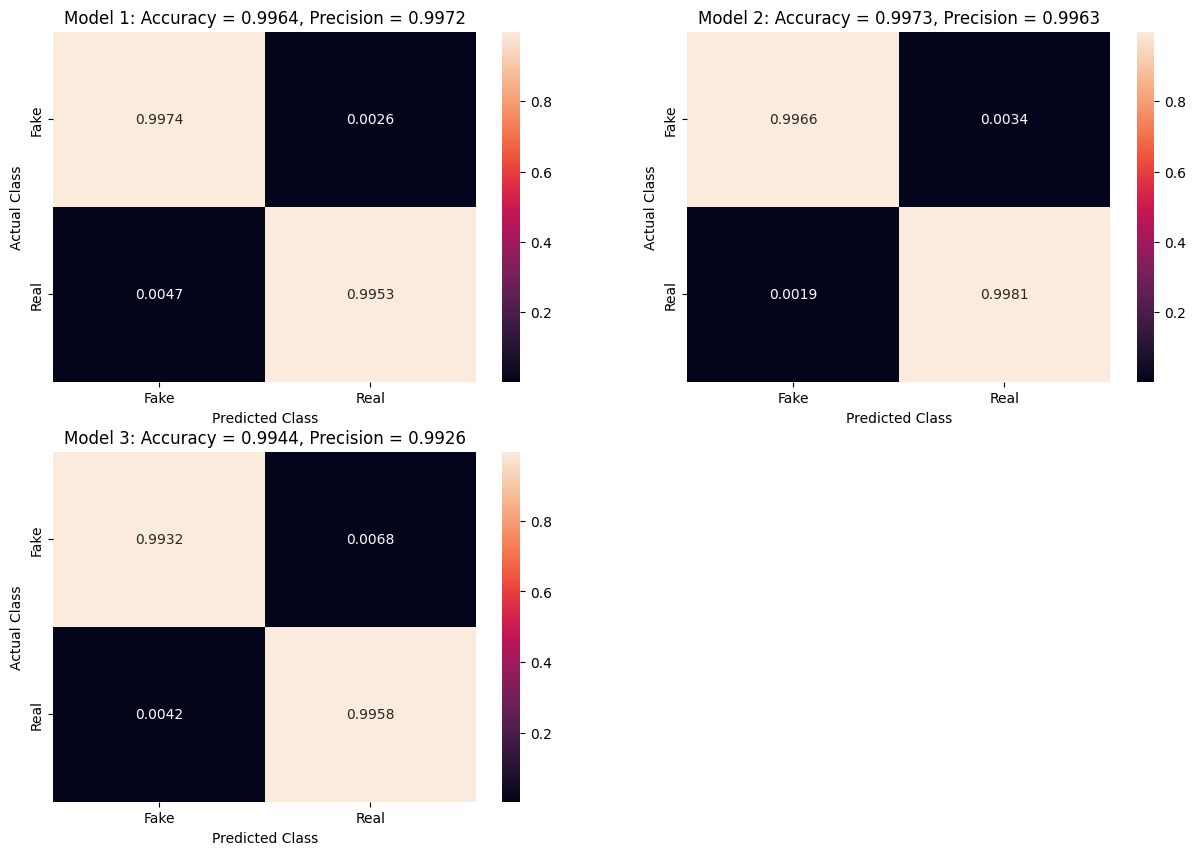

In [31]:
compare_models(y_test, [model1_pred, model2_pred, model3_pred])

## Model 4 (Transformer, Parameter Set 2)

In [32]:
num_heads = 3  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model4 = Model(inputs=inputs, outputs=preds)

model4.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=[Precision(name = "precision")]
)

model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 glove_token_and_position_e  (None, 1000, 100)         10261300  
 mbedding_1 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_1 (Trans  (None, 1000, 100)         134364    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_12 (Dropout)        (None, 100)               0   

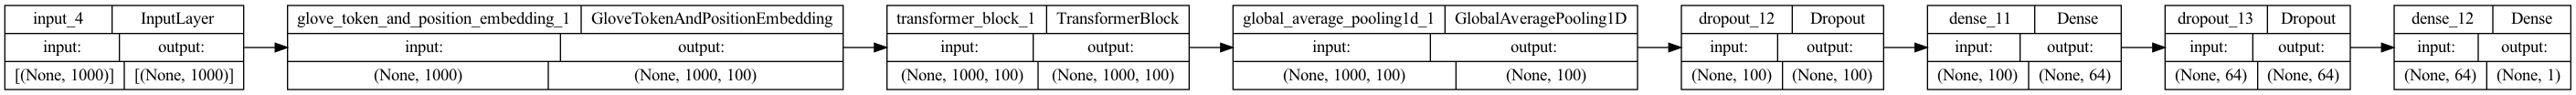

In [33]:
plot_model(
    model4, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [34]:
%%time

history4 = []
hist4 = model4.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=5, batch_size=128
)
history4.append(hist4)

Epoch 1/5
141/141 [==============================] - 447s 3s/step - loss: 0.2947 - precision: 0.8616 - val_loss: 0.0500 - val_precision: 0.9860
Epoch 2/5
141/141 [==============================] - 433s 3s/step - loss: 0.0732 - precision: 0.9740 - val_loss: 0.0324 - val_precision: 0.9907
Epoch 3/5
141/141 [==============================] - 423s 3s/step - loss: 0.0459 - precision: 0.9822 - val_loss: 0.0236 - val_precision: 0.9912
Epoch 4/5
141/141 [==============================] - 558s 4s/step - loss: 0.0329 - precision: 0.9867 - val_loss: 0.0207 - val_precision: 0.9930
Epoch 5/5
141/141 [==============================] - 1217s 9s/step - loss: 0.0226 - precision: 0.9913 - val_loss: 0.0243 - val_precision: 0.9894
CPU times: user 3h 43min 41s, sys: 1h 9min 19s, total: 4h 53min 1s
Wall time: 51min 17s


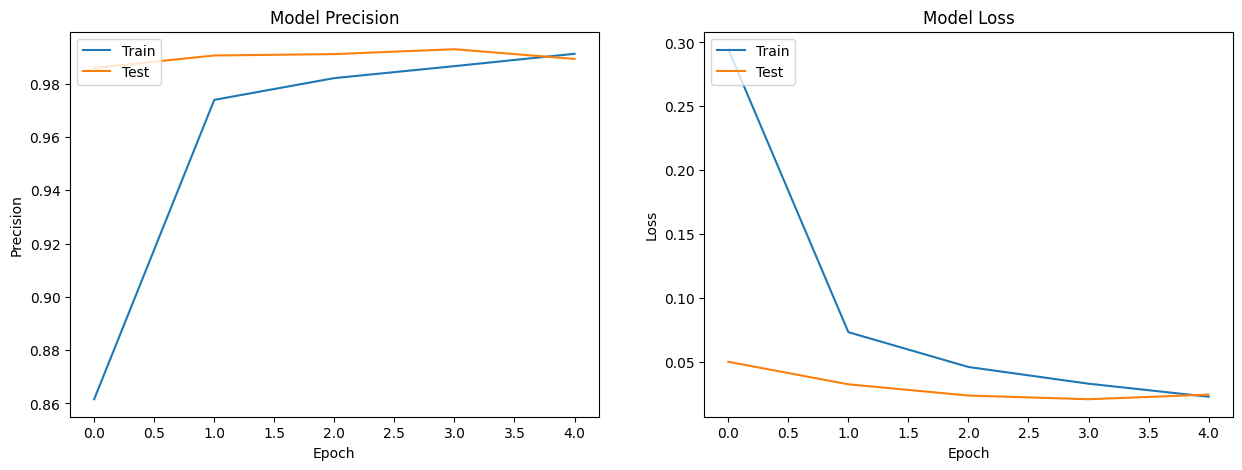

In [35]:
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history4])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [36]:
model4_proba = model4.predict(X_test)
model4_pred = np.round(list(map(lambda x: x[0], model4_proba)))

141/141 [==============================] - 41s 290ms/step


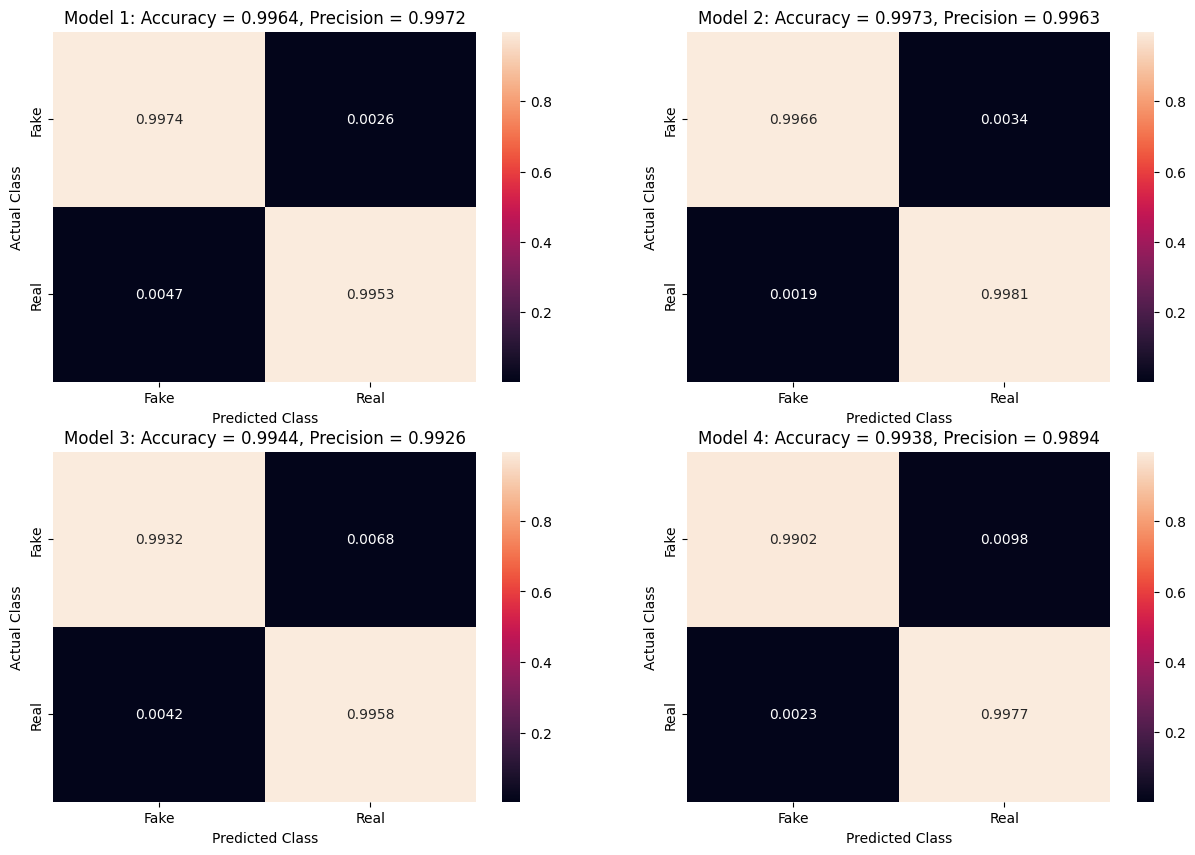

In [37]:
compare_models(y_test, [model1_pred, model2_pred, model3_pred, model4_pred])

## Transformer Comparison

In [38]:
# Function to conduct the McNemar test for 2 sets of predictions
# Returns true if we reject the null hypothesis (the models are different)
def mcnemar_test(y, yhat1, yhat2):
    # Calculate B and C
    B = 0
    C = 0
    for i in range(len(y)):
        # If yhat1 and yhat2 match, then neither B nor C
        if yhat1[i] == yhat2[i]:
            continue
        else:
            # If yhat1 and y match, then B
            if y[i] == yhat1[i]:
                B += 1
            # Else, C
            else:
                C += 1
    
    # Calculate test statistic
    x2 = ((abs(B - C) - 1) ** 2) / (B + C)
    print(x2)
    
    # Determine if we should reject the null hypothesis or not
    return x2 > 3.841

In [39]:
mcnemar_test(y_test, model3_pred, model4_pred)

0.26666666666666666


False

## Second Multiheaded Attention Layer

In [40]:
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model5 = Model(inputs=inputs, outputs=preds)

model5.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=[Precision(name = "precision")]
)

model5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000)]            0         
                                                                 
 glove_token_and_position_e  (None, 1000, 100)         10261300  
 mbedding_2 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_2 (Trans  (None, 1000, 100)         87632     
 formerBlock)                                                    
                                                                 
 transformer_block_3 (Trans  (None, 1000, 100)         87632     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_2  (None, 100)               0   

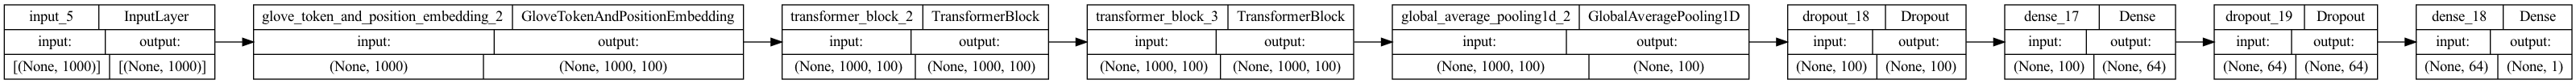

In [41]:
plot_model(
    model5, to_file='model5.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [42]:
%%time

history5 = []
hist5 = model5.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=5, batch_size=128
)
history5.append(hist5)

Epoch 1/5
141/141 [==============================] - 934s 7s/step - loss: 0.3268 - precision: 0.8350 - val_loss: 0.0520 - val_precision: 0.9888
Epoch 2/5
141/141 [==============================] - 586s 4s/step - loss: 0.0498 - precision: 0.9832 - val_loss: 0.0681 - val_precision: 0.9610
Epoch 3/5
141/141 [==============================] - 623s 4s/step - loss: 0.0359 - precision: 0.9848 - val_loss: 0.0238 - val_precision: 0.9912
Epoch 4/5
141/141 [==============================] - 559s 4s/step - loss: 0.0281 - precision: 0.9900 - val_loss: 0.0194 - val_precision: 0.9925
Epoch 5/5
141/141 [==============================] - 1123s 8s/step - loss: 0.0222 - precision: 0.9910 - val_loss: 0.0199 - val_precision: 0.9944
CPU times: user 5h 4min 13s, sys: 1h 28min 5s, total: 6h 32min 19s
Wall time: 1h 3min 45s


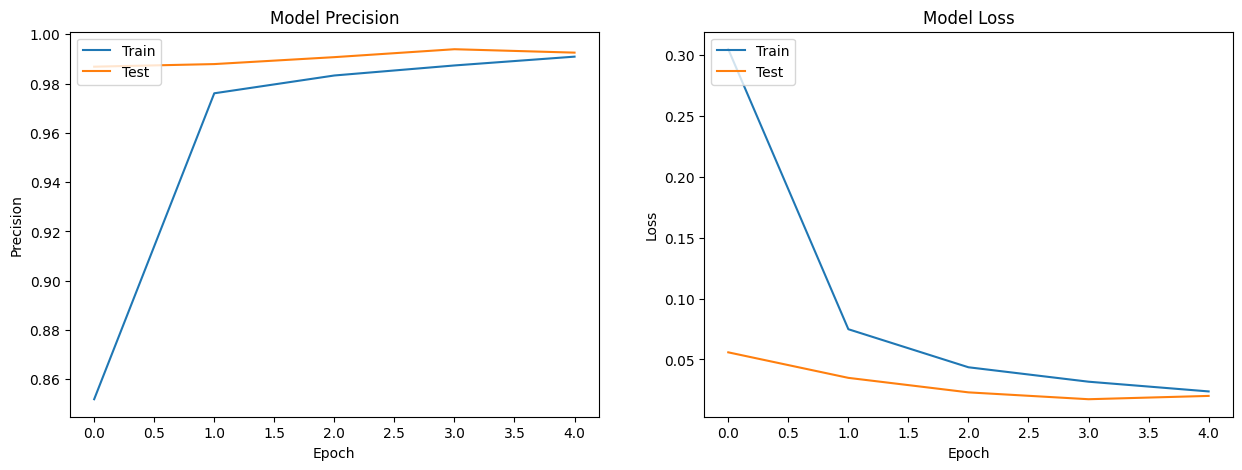

In [43]:
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history3])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [44]:
model5_proba = model5.predict(X_test)
model5_pred = np.round(list(map(lambda x: x[0], model5_proba)))

141/141 [==============================] - 56s 394ms/step


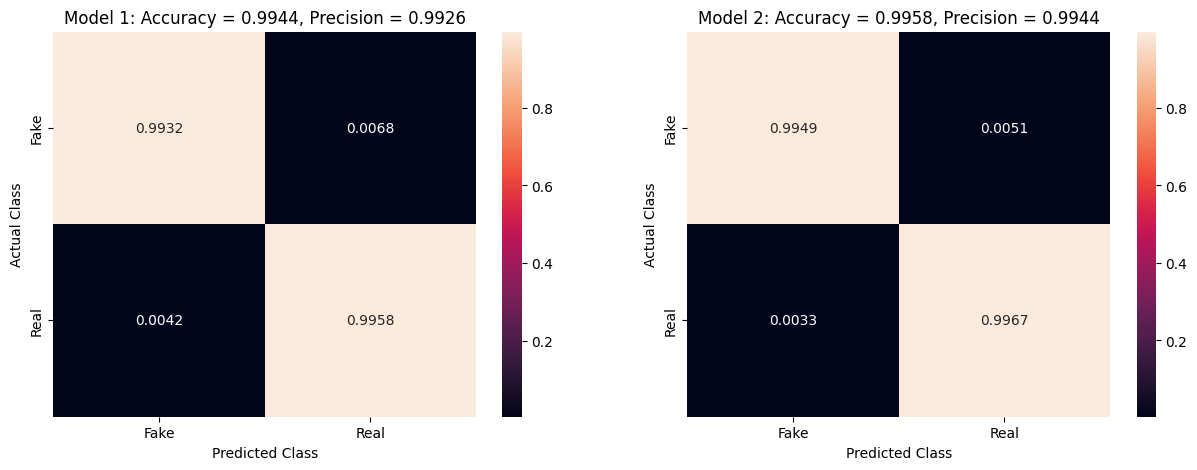

In [45]:
compare_models(y_test, [model3_pred, model5_pred])

## All Models Comparison

In [46]:
all_pred = [ model1_pred, model2_pred, model3_pred, model4_pred, model5_pred ]
for i in range(len(all_pred)):
    for j in range(i+1, len(all_pred)):
        print("Models {} and {}:".format(i+1, j+1))
        print(mcnemar_test(y_test, all_pred[i], all_pred[j]))
        print()

Models 1 and 2:
0.75
False

Models 1 and 3:
2.3703703703703702
False

Models 1 and 4:
3.5588235294117645
False

Models 1 and 5:
0.17391304347826086
False

Models 2 and 3:
5.76
True

Models 2 and 4:
8.035714285714286
True

Models 2 and 5:
1.894736842105263
False

Models 3 and 4:
0.26666666666666666
False

Models 3 and 5:
1.5625
False

Models 4 and 5:
3.3684210526315788
False



## ConceptNet Numberbatch vs GloVe

### Load ConceptNet Numberbatch Embeddings

In [47]:
%%time

EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../Datasets/numberbatch-en-19.08.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 516783 word vectors.
Embedding Shape: (101613, 300) 
 Total words found: 52291 
 Percentage: 51.46093511656973
CPU times: user 16.9 s, sys: 666 ms, total: 17.5 s
Wall time: 17.3 s


In [48]:
# save this embedding now
embedding_layer_numberbatch = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

### Refit Model 3 With ConceptNet Numberbatch

In [49]:
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer_numberbatch(sequence_input) # from previous embedding
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(35)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)
# Added an additional dense layer
x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model6 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
# Let's train the model 
model6.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=[Precision(name = "precision")]
)

model6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_7 (Embedding)     (None, 1000, 300)         30483900  
                                                                 
 conv1d_6 (Conv1D)           (None, 996, 64)           96064     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 199, 64)           0         
 g1D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 199, 64)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 195, 64)           20544     
                                                           

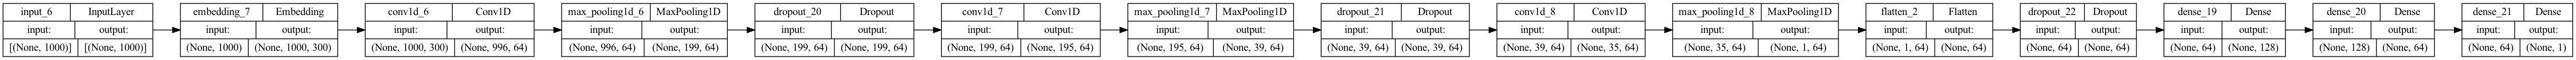

In [50]:
plot_model(
    model6, to_file='model6.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [51]:
%%time

history6 = []
hist6 = model6.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=5, batch_size=128
)
history6.append(hist6)

Epoch 1/5
141/141 [==============================] - 31s 214ms/step - loss: 0.1999 - precision: 0.9144 - val_loss: 0.0173 - val_precision: 0.9948
Epoch 2/5
141/141 [==============================] - 30s 214ms/step - loss: 0.0180 - precision: 0.9951 - val_loss: 0.0149 - val_precision: 0.9991
Epoch 3/5
141/141 [==============================] - 30s 216ms/step - loss: 0.0143 - precision: 0.9958 - val_loss: 0.0163 - val_precision: 0.9894
Epoch 4/5
141/141 [==============================] - 30s 215ms/step - loss: 0.0083 - precision: 0.9975 - val_loss: 0.0098 - val_precision: 0.9967
Epoch 5/5
141/141 [==============================] - 30s 214ms/step - loss: 0.0075 - precision: 0.9971 - val_loss: 0.0098 - val_precision: 0.9972
CPU times: user 19min 30s, sys: 2min 43s, total: 22min 14s
Wall time: 2min 31s


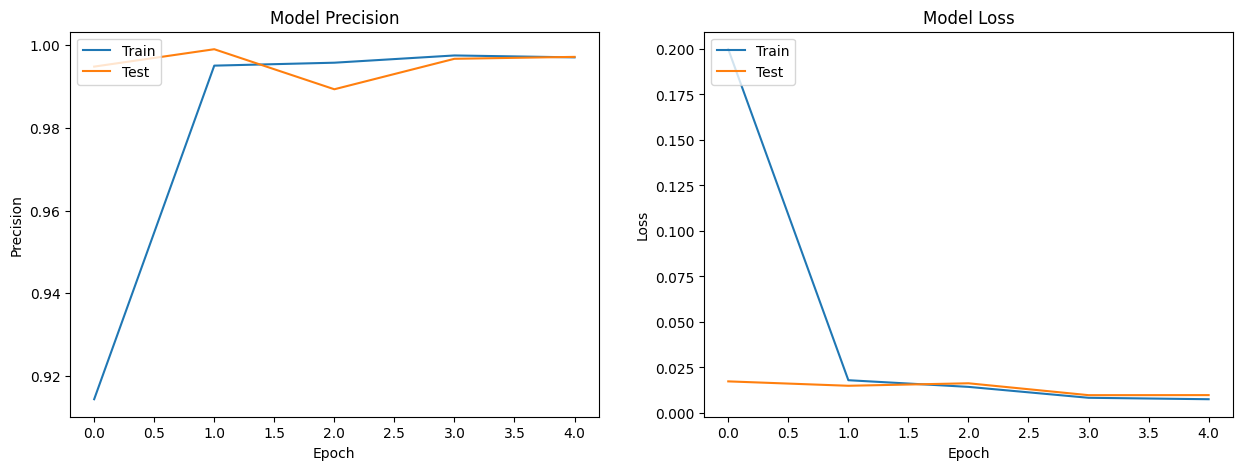

In [52]:
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history6])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [53]:
model6_proba = model6.predict(X_test)
model6_pred = np.round(list(map(lambda x: x[0], model6_proba)))

141/141 [==============================] - 3s 20ms/step


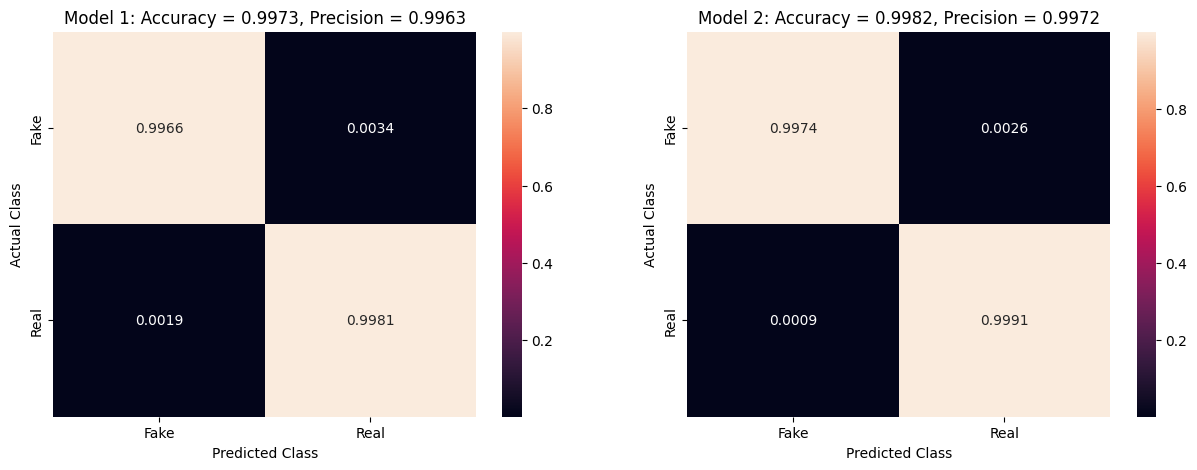

In [54]:
compare_models(y_test, [model2_pred, model6_pred])

In [55]:
mcnemar_test(y_test, model2_pred, model6_pred)

1.125


False